In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sympy.solvers import solve
from sympy import Symbol, re, series, pi, sqrt
from astropy import constants as const
from astropy import units
from scipy.integrate import quad, dblquad, nquad
import scipy.optimize as spopt
from scipy.interpolate import interp1d, interp2d
from matplotlib import rc

In [2]:
plt.rcParams.update({'font.size': 22})
rc('text', usetex=True)
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern']})
# plt.rcParams.update({'figure.autolayout': True})

/home/jagoras/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


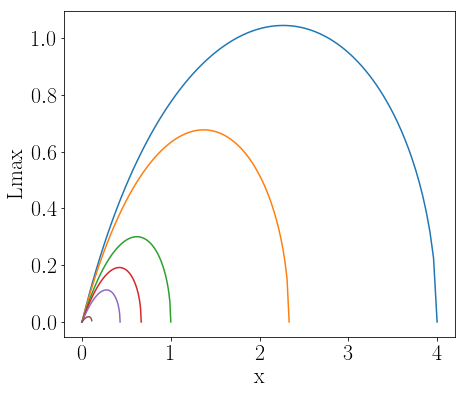

In [14]:
def lmax(eps, x):
    return (2*x**2*(1/(1+x) - eps))**0.5

l = np.linspace(0.0001,1, 100)
def x(eps):
    return np.linspace(0.0, (1/eps-1), 100)

plt.figure(figsize=[7,6])
e = [0.2 , 0.3, 0.5, 0.6, 0.7, 0.9]
for i in e:
    plt.plot(x(i), lmax(i, x(i)))

plt.xlabel('x')
plt.ylabel('Lmax')
plt.show()

In [15]:
# I_r as a function of L
def model(L, *par):
    return par[0]*L**par[1]+par[2]

x = Symbol('x')

ni = 50
eps = np.logspace(np.log10(0.9),np.log10(0.9999), ni)
# eps1 = 1 - np.geomspace(1e-5, 0.199, ni/2)
# eps2 = np.geomspace(0.8, 1, ni/2)
# epss = np.append(eps1, eps2)
# epss.sort()
pars_l = [] # fitting parameters for L
I_l = []

Larr = []
epsarr =[]

# for fixed values of ε calculate I_r vs L
for a in eps:
    x_m = solve(-2*a*x**2+(1-4*a)*x+2*(1-a),x) # dlmax/dx=0 to find the corresponding x for lmax_max
# x_m_arr = sym.lambdify((a,), x_m[1])(eps)
    l = np.linspace(1e-12, 0.999*lmax(a, float(max(x_m))), ni)
    integI=[]
    errI=[]
    
    for b in l:
        sol = solve(-2*a*x**3+2*(1-a)*x**2-b**2*x-b**2, x)
        x_neg = re(sol[0])
        x_min = float(re(sol[1]))
        x_max = float(re(sol[2]))
        
        # integration
        func = lambda x: (2/(1+x)-2*a-b**2/x**2)**0.5
#         func = lambda t: np.sqrt(2*a)*(x_max - x_min)**2 * ((1-t)*t*((x_max-x_min)*t+x_min-x_neg)/((x_max-x_min)*t+x_min))**0.5 / ((x_max-x_min)*t+x_min+1)
        integ, err = quad(func, x_min, x_max)
        integI.append(integ)
        errI.append(err)
        
        Larr.append(b)
        epsarr.append(a)
        I_l.append(integ)
        
#     I_l.append(integI)   
#     plt.errorbar(l, integI, yerr=errI, fmt='.')

#     p0 = [-1.9, 1, 1]
#     params, cov = spopt.curve_fit(model, l, integI, p0, sigma=errI)
#     pars_l.append(params)
#     plt.plot(l, model(l,*params), label='model')

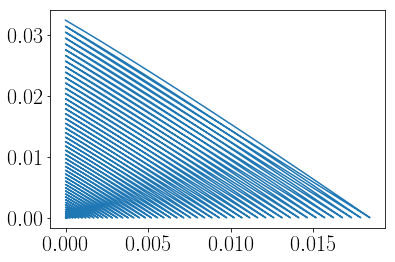

In [17]:
eps_interp = interp2d(I_l, Larr, epsarr)
plt.plot(Larr, I_l)

In [363]:
np.savetxt('L_params100', pars_l)
np.savetxt('I_l', I_l)
np.savetxt('l100', l)

In [5]:
pars_l = np.loadtxt('L_params100')
I_l = np.loadtxt('I_l100')
# l = np.loadtxt('l')
# eps = np.logspace(np.log10(0.75),np.log10(0.99), 50) # L params3

pars_l = np.array(pars_l)
l_index = np.average(pars_l[60:,1])
l_coef = np.average(pars_l[60:,0])

L parameters average (coef, index): -2.4028174015785297 1.0467780467197925


Text(0.5, 0, 'eps')

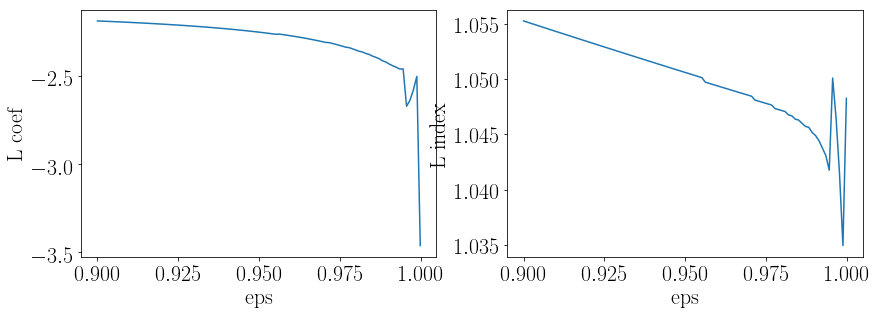

In [5]:
eps = np.logspace(np.log10(0.9),np.log10(0.9999), 100)

print('L parameters average (coef, index):', l_coef, l_index)

# pars_eps = np.array(pars_eps)
# eps_index = np.average(pars_eps[:,1])
# eps_coef = np.average(pars_eps[:,0])
# print('ε parameters average (coef, index):',eps_coef, eps_index)

plt.figure(figsize=[14,10])
# L parameters
plt.subplot(2,2,1)
plt.plot(eps, pars_l[:,0])
plt.ylabel('L coef')
plt.xlabel('eps')
plt.subplot(2,2,2)
plt.plot(eps, pars_l[:,1])
plt.ylabel('L index')
plt.xlabel('eps')

# # eps parameters
# plt.subplot(2,2,3)
# plt.plot(pars_eps[:,0])
# plt.ylabel('eps coef')
# plt.subplot(2,2,4)
# plt.plot(pars_eps[:,1])
# plt.ylabel('eps index')
# plt.show()

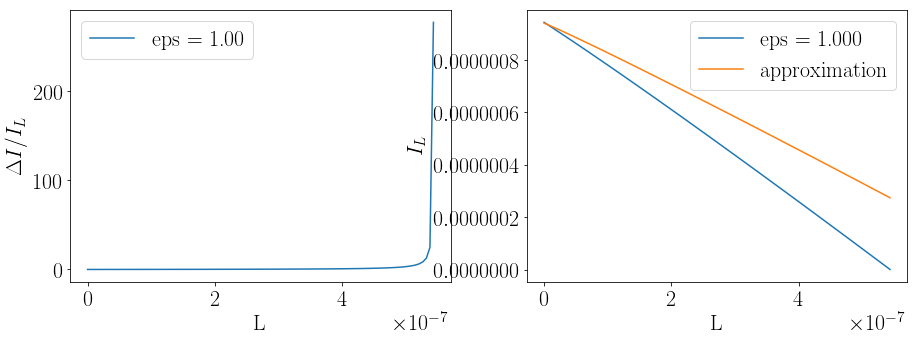

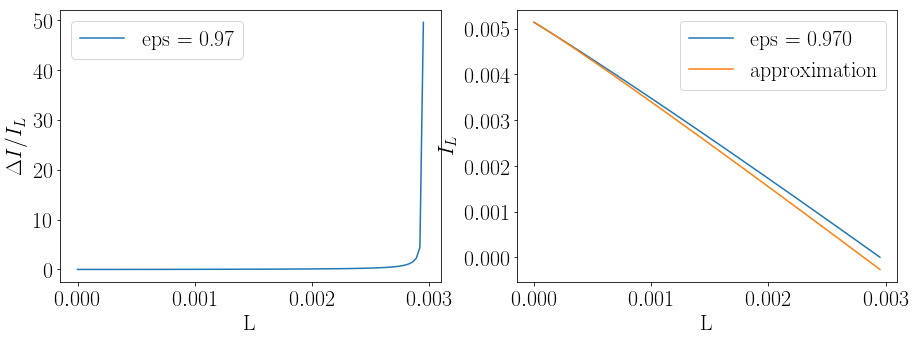

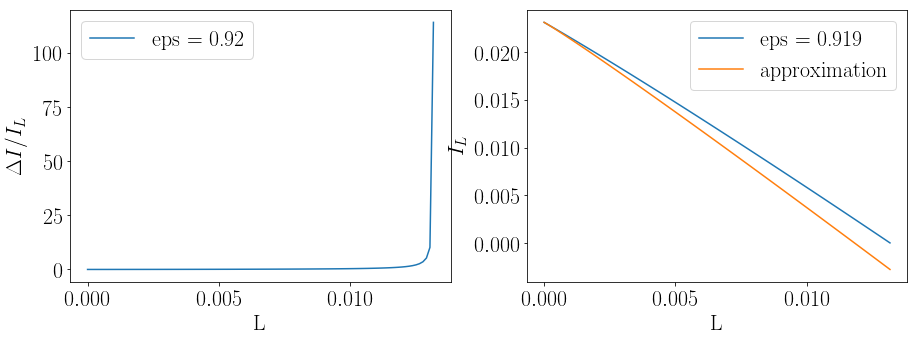

In [24]:
def plotMSE_L(i, I_l=I_l, eps=eps):
    x = Symbol('x')
    
#     eps = np.logspace(np.log10(0.75),np.log10(0.99), 50)
    eps = np.logspace(np.log10(0.9),np.log10(0.9999), 100)

    a = eps[i]
    x_m = solve(-2*a*x**2+(1-4*a)*x+2*(1-a),x) # dlmax/dx=0 to find the corresponding x for lmax_max
#     l = np.linspace(1e-4, 0.999*lmax(a, float(max(x_m))), 50)
    l = np.linspace(1e-12, 0.999*lmax(a, float(max(x_m))), 100)
    
    I_lmodel = l_coef*l**l_index + pars_l[i,2]
    mse_l = np.abs(I_l[i] - I_lmodel)/(I_l[i])
    
    plt.figure(figsize=[15,5])
    plt.subplot(1,2,1)
    plt.plot(l, mse_l, label='eps = %.2f' %eps[i])
    plt.xlabel('L')
    plt.ylabel(r'$\Delta I/I_L$')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(l, I_l[i], label='eps = %.3f' %eps[i])
    plt.plot(l, I_lmodel, label='approximation')
    plt.xlabel('L')
    plt.ylabel(r'$I_L$')
    plt.legend()
    
plotMSE_L(99)
plotMSE_L(70)
plotMSE_L(20)

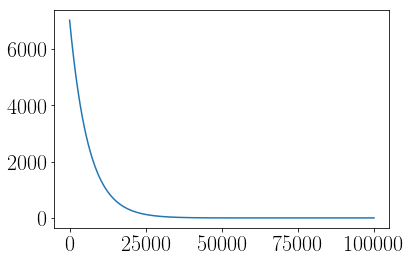

In [15]:
# I_r(ε,0)

n = 1e5
# eps = np.logspace(np.log10(0.8),0,n)
# eps = 1 - np.logspace(np.log10(1e-7), np.log10(0.2), n)

eps1 = 1 - np.geomspace(1e-7, 0.5, n/2)
eps2 = np.geomspace(1e-7, 1, n/2)
eps = np.append(eps1, eps2)
eps.sort()
I_eps = np.sqrt(2) * (np.arccos(eps**0.5)/eps**0.5 - (1-eps)**0.5)
# interpolation
eps_I = interp1d(I_eps, eps)

plt.plot(I_eps)

In [78]:
# density profile

## distribution function
def f_dist(eps):
    return eps**0.5/(1-eps)**2 * ((1-2*eps)*(8*eps**2-8*eps-3) + 3*np.arcsin(eps**0.5)/np.sqrt(eps*(1-eps)))

def f_dist2(x):
    return ((3*np.pi)/(2*np.sqrt(1-x))+3)/(x-1)**2 - 1/(2*(x-1))-203/8- (441*(x-1))/16 -671/128*(x-1)**2 + 169/256*(x-1)**3

## parameters
rho_sim = np.loadtxt('DC_Simulation/rho_sim_100000_soft1')
rsim = np.loadtxt('DC_Simulation/rbin_100000_soft1')

c = const.c.to(units.parsec/units.s)
convert = (units.GeV/units.cm**3/c**2).to(units.solMass/units.parsec**3)
def H_params(m, M, a, c=c, r=rsim[:,0]):
    G = const.G.to(units.parsec**3/units.solMass/units.s**2)
    Rs = (2*G*m/c**2).to(units.parsec)
    m_tild = (m/M).value
    Lmin = ((2*c * Rs)/(a*G*M)**0.5).value

#     r = np.logspace(np.log10(4.00001*Rs.value), 2, 100)
    x_arr = r/a.value

    rho_H = (M/(2*np.pi*a**3)) / ((r/a.value)*(1+r/a.value)**3)
    return Rs, m_tild, Lmin, r, x_arr, rho_H

# self-annihilation
t_bh = 1e10 *units.year # age of the BH
sigmav = 3e-26 *units.cm**3/units.s # WIMP annihilation cross-section
m_part = (100 *units.GeV/c**2).to(units.solMass) # DM particle mass
rho_core = (m_part/(sigmav*t_bh)).to(units.solMass/units.parsec**3).value

asd = 500
Menc = 2*np.pi* 2.178792542149263 * 100**3 * asd**2/(100+asd)**2
Menc

9506775.894600492

In [42]:
# density profile
## integration

def H_integ(m_tild, a, Rs, Lmin, x_arr):
    int_rho_arr = []
    int_err = []

    for xi in x_arr:

        def f_integ(z, u):
            eps_max = m_tild/(xi)*(1 - 4*Rs/(a*xi))
            eps_f = u*eps_max
            Lmax2 = 2*xi**2*(m_tild/(xi) - eps_f)
            l = np.sqrt(z*Lmax2 + (1-z)*Lmin**2)
            eps_i = eps_I(np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index)
            
            # distribution function
            f_H = f_dist(eps_i)

            return np.sqrt((Lmax2-Lmin**2)/(1-z)) * f_H

#         integration
        integ_rho = dblquad(f_integ, 0, 1, 0, 1, epsrel=1e-3)
        int_rho_arr.append(integ_rho[0])
        int_err.append(integ_rho[1])
    return int_rho_arr, int_err

# two quads
def H_integ2quad(m_tild, a, Rs, Lmin, x_arr):
    int_rho_arr = []
    int_err = []

    for xi in x_arr:
        def z_integ(z):
            def u_integ(z, u):
                eps_max = m_tild/(xi)*(1 - 4*Rs/(a*xi))
                eps_f = u*eps_max
                Lmax2 = 2*xi**2*(m_tild/(xi) - eps_f)
                l = np.sqrt(z*Lmax2 + (1-z)*Lmin**2)
                eps_i = eps_I(np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index)
                
#                 eps_i = 1 - (2*2**(1/3)* m_tild**(2/3)* np.pi**(2/3))/(5**(2/3)*eps_f**(1/3))
  

                # distribution function
                f_H = f_dist(eps_i)

                return np.sqrt((Lmax2-Lmin**2)/(1-z)) * f_H
            integ1 = quad(lambda u: u_integ(z,u), 0,1, epsrel=1e-3, points=(0,0.9, 0.99, 0.999,1))
            return integ1[0]
        integ2 = quad(z_integ, 0,1, epsrel=1e-3, points=(0.9, 0.99, 0.999,1))
        int_rho_arr.append(integ2[0])
        int_err.append(integ2[1])
        print('.')
    return int_rho_arr, int_err

def H_integ_init(a, Lmin, x_arr):
    int_rho_arr = []
    int_err = []

    for xi in x_arr:
        def z_integ(z):
            def u_integ(z, u):
                eps_max = 1/(xi+1)
                eps_f = u*eps_max
                Lmax2 = 2*xi**2*(1/(xi+1) - eps_f)
                l = np.sqrt(z*Lmax2 + (1-z)*Lmin**2)
                eps_i = eps_f

                # distribution function
                f_H = f_dist(eps_i)

                return np.sqrt((Lmax2-Lmin**2)/(1-z)) * f_H
            integ1 = quad(lambda u: u_integ(z,u), 0,1, epsrel=1e-3, points=(0.999,1))
            return integ1[0]
        integ2 = quad(z_integ, 0,1, epsrel=1e-3, points=(0.999,1))
    return integ2[0], integ2[1]

In [71]:
Rs_arr, m_tild, Lmin, rho_H = np.zeros(9), np.zeros(9), np.zeros(9), []
m = [1e4,4e6,1e4, 2.6e6,2.6e6,2.6e6, 1e7, 1e7, 1e7] *units.solMass # BH mass
a = [20e3, 100, 1000e3,3e3, 5e3, 7e3,3e3, 5e3, 7e3] *units.parsec # scale radius

rho0_low = 2.178792542149263
rho0_high = 0.0002178792542126022
M = 2*np.pi* rho0_low * a[1]**3 *units.solMass # initial halo mass
G = const.G
# M = 1e12 *units.solMass # initial halo mass


Rs, m_tild, Lmin, r, x_arr, rho_H = H_params(m[1], M, a[1])
# m_tild = m_tild.reshape(1,9, order='F')
# Rs = Rs.reshape(1,9, order='F')
M

<Quantity 13689757.28822471 pc3 solMass>

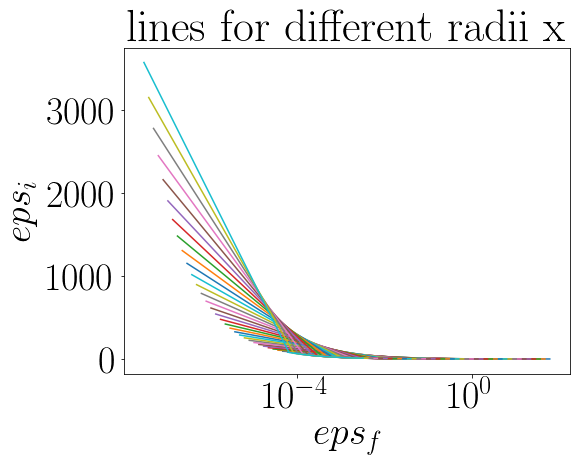

In [72]:
# TESTING
plt.figure(figsize=(8,6))

# eps1 = 1 - np.geomspace(1e-10, 0.199, 1000)
# eps2 = np.geomspace(0.8, 1, 1000)
# epstest = np.append(eps1, eps2)
# epstest.sort()

# epstest = np.logspace(np.log10(0.8),0,n)
    
for xi in x_arr:
    u = np.linspace(0.00001,1,50)
    z = np.linspace(0.00001,1,50)
    eps_max = m_tild/(xi)*(1 - 4*Rs.value/(xi*float(a[1].value)))

    eps_f = u*eps_max
    Lmax2 = 2*xi**2*(m_tild/(xi) - eps_f)
    l = np.sqrt(z*Lmax2 + (1-z)*Lmin**2)

#     print(max((np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index)))
    eps_i = eps_I(np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index)
#     for epsi in eps_f:
#         Lmax2 = 2*xi**2*(m_tild/(xi) - epsi)
#         l = np.sqrt(z*Lmax2 + (1-z)*Lmin**2)
#         for li in l:
#             eps_i = eps_interp(np.pi*(m_tild/(np.sqrt(2*epsi)) - li), li)
#             print(epsi)
            
#     eps_i = test(np.pi*(m_tild/(np.sqrt(2*eps_f)) - l), l)
#     plt.plot(eps_f, eps_i)

    plt.plot(eps_f, np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index)
#     plt.plot(epstest, I_eps, color='red')
    plt.xscale('log')
#     plt.xlim(1e-1,2e4)
#     plt.ylim(0.9989,1.001)
    plt.title(r'lines for different radii x')
    plt.xlabel(r'$eps_f$')
    plt.ylabel(r'$eps_i$')


In [73]:
int_rho_arr, int_err = H_integ2quad(m_tild, a[1], Rs, Lmin, x_arr)

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


In [74]:
def spike_model(r, *par, Rs):
    return par[0]*(1-4*Rs/r)**par[1] * r**par[2]

def rho0(r0, gamma): # from GS
    return (1-gamma/3)*0.0062*(8500/r0)**gamma

def rho(m_tild, M, a, Rs, int_rho_arr, x_arr):
    eps_max = m_tild/(x_arr)*(1 - 4*Rs/(a*x_arr))
    return (1/(2**0.5 * (2*np.pi)**2 *x_arr) * (M/a**3)*eps_max) * np.array(int_rho_arr)
def rho2test(M, a, int_rho_arr, x_arr):
    eps_max = 1/(x_arr+1)
    return (1/(2**0.5 * (2*np.pi)**2 *x_arr) * (M/a**3)*eps_max) * np.array(int_rho_arr)

rho = rho(m_tild, M, a[1], Rs, int_rho_arr, x_arr)
# np.savetxt('spike_H 2e6 a3kpc correct', rho)
# np.savetxt('int_rho_arr correct 2.6', int_rho_arr)

In [29]:
np.savetxt('rho_sp_a100 compare_sim100000_40p_soft1_m2e6', rho)
# np.savetxt('Hernq_integ star_err2', int_err)

In [32]:
# rho = np.loadtxt('rho_sp_nfw_sunpars')
# rho2 = np.loadtxt('rho_sp1 compare with Hernq. a1e3kpcMcentr')
# rho = np.loadtxt('rho_sp_nfw compare_sim_resid_30000')

rho2 = np.loadtxt('rho_sp1 compare with Hernq_a1')
rho3 = np.loadtxt('rho_sp1 compare with sim_100000 nfw_40p')




# rho_GS = np.loadtxt('rho_sp1 compare array')
# r_GS = np.logspace(np.log10((4+1e-8)*Rs.value), 1, 200)

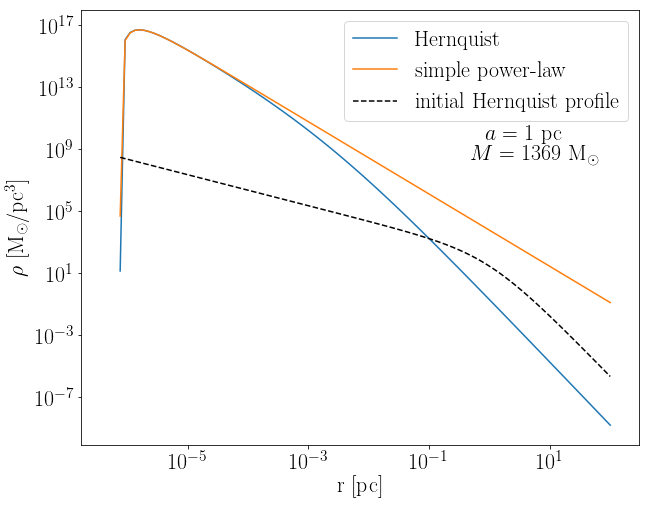

In [42]:
plt.figure(figsize=[10,8])

# r = np.logspace(np.log10(4.0001*Rs.value), 2, 70)
plt.plot(r, rho, label='Hernquist')
# plt.plot(r_GS, rho2, label='a=%.f kpc, ρ$_0$=%.3f M$_\odot$/pc$^3$' % (r_Hs/1e3, rho_H0new))
# plt.plot(r, rho3, label=r'simple power-law, $L=0$')
plt.plot(r, rho2, label=r'simple power-law')

plt.plot(r, rho_H, linestyle='--', color='k', label='initial Hernquist profile')
plt.text(0.5,1e8, r'$a=%.f$ pc\\$M=%.f$ M$_\odot$' % (a[1].value, M.value))

plt.xlabel('r [pc]')
plt.ylabel(r'$\rho$ [M$_\odot$/pc$^3$]')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(0.9*Rs.value,300)
# plt.ylim(1e-5)
# plt.savefig('Hernquist plots/compare params/correct/Hernq_GS_a1', dpi=200)

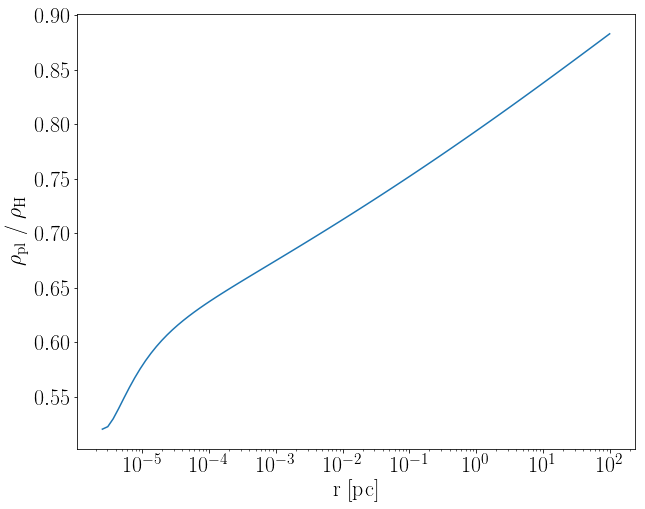

In [24]:
plt.figure(figsize=[10,8])

plt.plot(r[5:], rho2[5:]/rho[5:])
plt.xlabel('r [pc]')
plt.ylabel(r'$\rho_\mathrm{pl}$ / $\rho_\mathrm{H}$')
plt.xscale('log')
# plt.yscale('log')
# plt.ylim(2.05,2.15)

# Compare with simulation

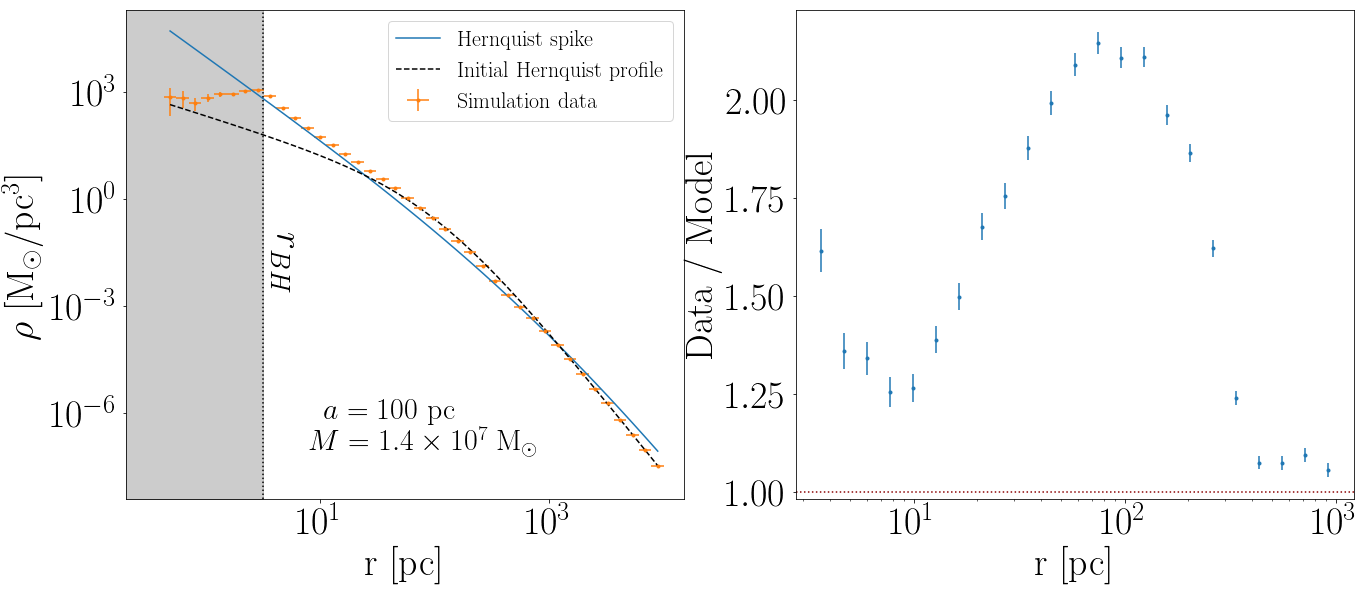

In [77]:
# rho = np.loadtxt('rho_sp_a100 compare_sim100000_40p_soft1_m2e6')
rlow = 3.12 # position of BH
r_h = 1e3

plt.figure(figsize=[22,9])
plt.rcParams.update({'font.size': 38})
# plt.subplots_adjust(right=1.1)

plt.subplot(121)
plt.plot(r, rho, label='Hernquist spike')
# plt.plot(r, rho3, label='Simple power-law')
plt.plot(r, rho_H, linestyle='--', color='k', label='Initial Hernquist profile')
plt.text(8,7e-8, r'$a=%.f$ pc\\$M=%.1f \times 10^{7}$ M$_\odot$' % (100, M.value/1e7), fontsize=30)

plt.errorbar(rsim[:,0], rho_sim[:,0], xerr=[rsim[:,1],rsim[:,2]], yerr=rho_sim[:,1], fmt='.', label='Simulation data')
plt.axvline(rlow, linestyle=':', color='k')
plt.text(rlow,0.02, '$r_{BH}$', rotation=-90)

plt.fill_betweenx([4e-9,2.1e5],rlow, 0.2, alpha=0.4, color='grey')
plt.xlabel('r [pc]')
plt.ylabel(r'$\rho$ [M$_\odot$/pc$^3$]')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=22)
plt.ylim(4e-9, 2e5)
plt.xlim(0.2, 1.5e4)

plt.subplot(122)

plt.errorbar(r[(r>rlow) & (r<r_h)], rho_sim[(r>rlow) & (r<r_h),0]/rho[(r>rlow) & (r<r_h)], yerr=rho_sim[(r>rlow) & (r<r_h),1]/rho[(r>rlow) & (r<r_h)], fmt='.')
plt.axhline(1, color='darkred', linestyle=':')
# plt.text(29,0.8, '$r_h=%.f$ pc' %r_h)

plt.xlabel('r [pc]')
plt.ylabel('Data / Model')

plt.xscale('log')
plt.savefig('Hernquist plots/compare params/correct/Hernq_sim_a100_N1e5_soft1_bh2e6_118h1.pdf', bbox_inches='tight', format='pdf')

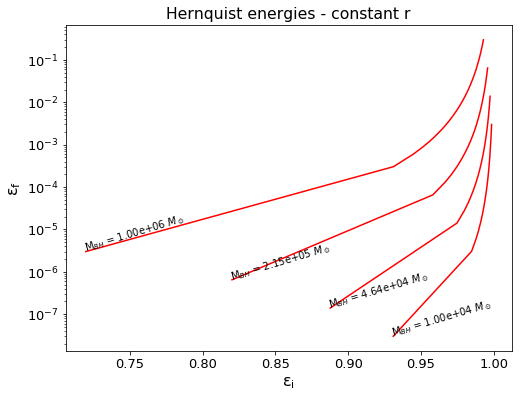

In [13]:
# psi_star = 1/(1+1e-3/a1.value)
plt.figure(figsize=[8,6])
plt.titles[i]('Hernquist energies - constant r')

def plot_eps(m, m_tild, a, Rs, Lmin):
    # for xi in x_arr:
    xi=1/a.value
    u = np.linspace(0.00001,1,1000)
    z = np.linspace(0.00001,1,1000)
    eps_max = m_tild/(xi)*(1 - 4*Rs/(a*xi))
    eps_f = u*eps_max
    Lmax2 = 2*xi**2*(m_tild/(xi) - eps_f)
    l = z*Lmax2 + (1-z)*Lmin**2
    #         eps_i = ((1/A * (np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index + A)) ** (1/B)).value
    eps_i = eps_I(np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index)
    plt.plot(eps_i, eps_f, color='red')

    p1 = plt.gca().transData.transform_point((eps_i[0], eps_f[0]))
    p2 = plt.gca().transData.transform_point((eps_i[400], eps_f[400]))
    dy = (p2[1] - p1[1])
    dx = (p2[0] - p1[0])
    rotn = np.degrees(np.arctan2(dy, dx))
    plt.text(eps_i[0], eps_f[0], 'M$_{BH}$ = %.2e $M_\odot$' %m, rotation=rotn, rotation_mode='anchor', fontsize=10)

m_arr = np.logspace(4, 6, 4)
for mi in m_arr:
    Rs, m_tild, Lmin, r, x_arr, rho_H = H_params(mi*units.solMass, 1e10, 3e3 *units.parsec)
    plot_eps(mi, m_tild, 3e3 *units.parsec, Rs, Lmin)
    
# plt.axhline(psi_star, linestyle=':', color='k')
# plt.text(1e-8, 0.99, "$\psi(R_{\star})$")
# plt.text(1e2,0.86, 'R$_{\star}=10^{-4}$ pc')
# plt.ylim(0.99)
plt.ylabel('ε$_\mathrm{f}$', fontsize=16)
plt.xlabel('ε$_\mathrm{i}$', fontsize=16)
plt.yscale('log')
plt.show()


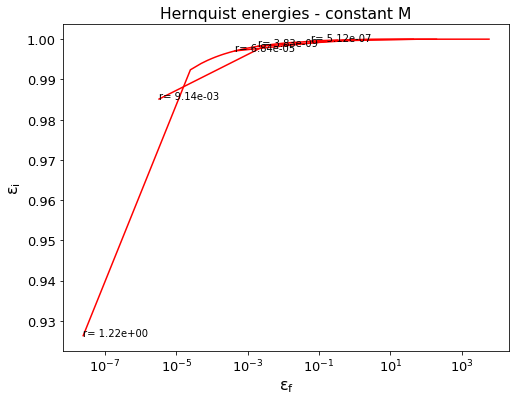

In [10]:
plt.figure(figsize=[8,6])
plt.titles[i]('Hernquist energies - constant M')

def plot_eps(m, m_tild, a, Rs, Lmin):
    for xi in x_arr[::10]:
#         xi=1/a.value
        u = np.linspace(0.00001,1,100)
        z = np.linspace(0.00001,1,100)
        eps_max = m_tild/(xi)*(1 - 4*Rs/(a*xi))
        eps_f = u*eps_max
        Lmax2 = 2*xi**2*(m_tild/(xi) - eps_f)
        l = z*Lmax2 + (1-z)*Lmin**2
        #         eps_i = ((1/A * (np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index + A)) ** (1/B)).value
        eps_i = eps_I(np.pi*(m_tild/(np.sqrt(2*eps_f)) - l) - l_coef*l**l_index)
        plt.plot(eps_f, eps_i, color='red')

        p1 = plt.gca().transData.transform_point((eps_i[0], eps_f[0]))
        p2 = plt.gca().transData.transform_point((eps_i[5], eps_f[5]))
        dy = (p2[1] - p1[1])
        dx = (p2[0] - p1[0])
        rotn = np.degrees(np.arctan2(dy, dx))
        plt.text(eps_f[0], eps_i[0], 'r= %.2e' %(xi*a.value), fontsize=10)

# m_arr = np.logspace(4, 6, 5)
# for mi in m_arr:
mi = 1e4
Rs, m_tild, Lmin, r, x_arr, rho_H = H_params(mi*units.solMass, 1e10, 3e3 *units.parsec)
plot_eps(mi, m_tild, 3e3 *units.parsec, Rs, Lmin)

plt.ylabel('ε$_\mathrm{i}$', fontsize=16)
plt.xlabel('ε$_\mathrm{f}$', fontsize=16)
plt.xscale('log')
plt.show()

For higher BH mass the final energies of the particles are higher, the potential increases so the energy of the particles increases too.

For higher BH mass, the initial energies of the particles have a bigger range. They also have a bigger range at higer radii.

Hernq. enclosed mass: $M_H(r)=2\pi \rho_0 a^3 \frac{r^2}{(a+r)^2}$

simple power-law: $M(r)=2\pi \rho_0 r^2/r_0$

Text(0.5, 0, 'r [pc]')

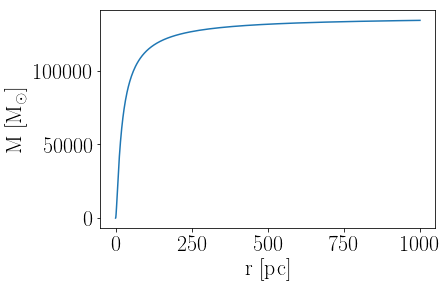

In [4]:
r_enc = np.logspace(-5, 3, 500)
a_sim = 10
Menc = 2*np.pi* 21.787925421492627 * a_sim**3 * r_enc**2/(a_sim+r_enc)**2
plt.plot(r_enc,Menc)
plt.ylabel(r'M [M$_\odot$]')
plt.xlabel('r [pc]')

# NFW - Hernq. initial profiles

In [28]:
# NFW - Hernq. compare
r = np.logspace(2, 5, 100)

r_0 = 16.1e3
rho_0 = 0.014 #0.471*convert # (M/(2*np.pi*a[0]**3))
rho_sun = 0.471*convert.value

r_max = 8.08e3 # Sun's radius
M_nfw = 4*np.pi*rho_0*r_0**3 * (np.log((r_0 + r_max)/r_0) - r_max/(r_0+r_max))
rho_H0s = M_nfw * (2*np.pi * r_0**3*r_max**2 / (r_0 + r_max)**2)**(-1) # fixing at sun's enclosed mass
rho_H0d = rho_sun * (8.08e3/r_0) * (1+8.08e3/r_0)**3 # fixing at sun's density


# fixing both sun's mass and density
x = Symbol('x', positive=True)
r_Hs = solve((M_nfw * (2*np.pi * x**3*r_max**2 / (x + r_max)**2)**(-1)) - (rho_sun * (r_max/x) * (1+r_max/x)**3), x)[0]
rho_H0new = rho_sun * (8.08e3/r_Hs) * (1+8.08e3/r_Hs)**3 # fixing at sun's density

# fixing the Hernquist profile with GS at low radii
r1 = 1
rho_GS0 = rho_H0new
r_GS0 = rho_GS0 * rho_H0new / ((r1/r_Hs)/(1+r1/r_Hs))

rhoH0s = [rho_H0s, rho_H0d, rho_0, (1e12/(2*np.pi*20e3**3)), rho_H0new]
titles = ['$M_{NFW}(r_{\odot})=M_H(r_{\odot})$',r'$\rho_{NFW}(r_{\odot})=\rho_H(r_{\odot})$',\
          r'$\rho_{0,NFW}=\rho_{0,H}$',r'SFW parameters $\rho_{0,NFW}=\rho_{0,H}$', r'     $M_{NFW}(r_{\odot})=M_H(r_{\odot})$ and $\rho_{NFW}(r_{\odot})=\rho_H(r_{\odot})$']
r0s = [r_0, r_0, r_0, 20e3, r_0]
rho0s = [rho_0, rho_0, rho_0, (1e12/(2*np.pi*20e3**3)), rho_0]
r_H0s = [r_0, r_0, r_0, 20e3, r_Hs]

# calculate r_h
import sympy as sym
def r_h(i, M_bh, j):
    rh = Symbol('$r_h$', positive=True)
    if (j=='H'):
        return (solve(2* np.pi*rhoH0s[i] *(r_H0s[i]**3* rh**2)/((r_H0s[i] + rh)**2)-2*M_bh, rh)[0])
    elif j=='NFW':
        return sym.nsolve(4*np.pi*rho0s[i]*r0s[i]**3 * (sym.log((r0s[i] + rh)/r0s[i]) - rh/(r0s[i]+rh)) - 2*M_bh, rh, 60.741)
    
print(r_Hs, rho_H0new, r_h(4, 1e7, 'H'))
# sd = Symbol(r'\rho', positive=True)
# sr = Symbol('r_s', positive=True)
# sym.integrate(4*sd/((x/sr)*(1+x/sr)**2),x)

27355.3624059166 0.00796477308477558 121.406043129656


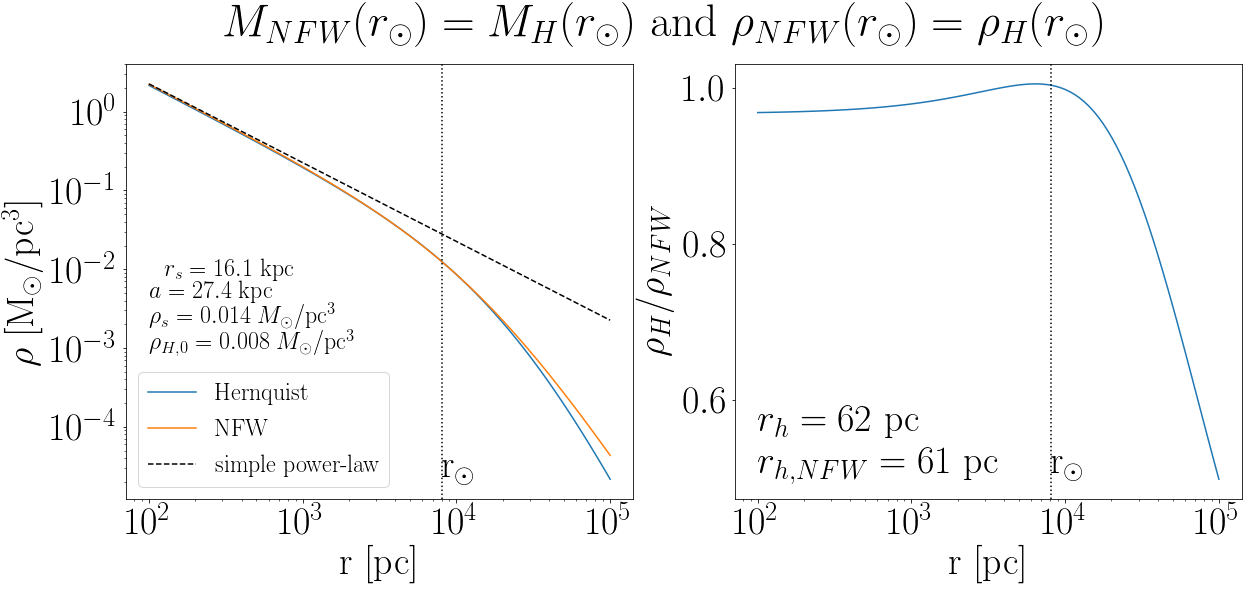

In [23]:
def plot_rhoi(rho_H0, title, i, N, r_H0, r_0=r_0, rho_0=rho_0):
    
    rho_pl = rho_0 * (r/r_0)**(-1)
    rho_H = rho_H0 / ((r/r_H0)*(1+r/r_H0)**3)
    rho_nfw = rho_0 / ((r/r_0)*(1+r/r_0)**2)

    plt.subplot(N,2,2*i+1)
    plt.suptitle(title)

    # plt.text(8.08e3, 0.471*convert.value, '.')
    plt.plot(r, rho_H ,label='Hernquist')
    plt.plot(r, rho_nfw, label='NFW')
    plt.plot(r, rho_pl, label='simple power-law', linestyle='--', color='k')
    plt.text(1e2, 9e-4, r'$r_s=%.1f$ kpc\\$a=%.1f$ kpc \\$\rho_{s}=%.3f$ $M_\odot$/pc$^3$ \\$\rho_{H,0}=%.3f$ $M_\odot$/pc$^3$'\
             %(r_0/1e3, r_H0/1e3, rho_0, rho_H0), fontdict={'size':24})
    plt.axvline(8.08e3, linestyle=':', color='k')
    plt.text(8.08e3, 2e-5, 'r$_\odot$')
    
    plt.ylabel(r'$\rho$ [M$_\odot$/pc$^3$]')
    plt.xlabel('r [pc]')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(fontsize=24)

    plt.subplot(N,2,2*i+2)
    plt.plot(r, rho_H/rho_nfw)
    plt.axvline(8.08e3, linestyle=':', color='k')
    plt.text(8.08e3, 0.5, 'r$_\odot$')
    plt.text(1e2,0.5, '$r_h=%.f$ pc \n$r_{h,NFW}=%.f$ pc' %(r_h(4,2.6e6, 'H'), r_h(4,2.6e6, 'NFW')))
#     plt.axvline(r_h(i,m[3].value), linestyle=':', color='red')

    plt.xscale('log')
    plt.xlabel('r [pc]')
    plt.ylabel(r'$\rho_H$/$\rho_{NFW}$')
    plt.savefig('Hernquist plots/nfw-H compare/nfw_H_mass_density', bbox_inches='tight', format='pdf')
    plt.show()

# for i in range(0,5):
#     plt.figure(figsize=(16,30))
#     plot_rhoi(rhoH0s[i], titles[i], i, 5, r_H0s[i],r0s[i], rho0s[i])
plt.rcParams.update({'font.size': 38})

plt.figure(figsize=(20,8))
plot_rhoi(rhoH0s[4], titles[4], 0, 1, r_H0s[4],r0s[4], rho0s[4])

# plt.figure(figsize=(16,6))
# plot_rhoi(rho_H0new, 'fixing both mass and density at Rsun', 0, 1, r_Hs,r_0, rho_0)


In [146]:
# introducing a protostar
def protostar(r, Rstar, a=a.value):
    x = r/a
    int_star =[]
    
    for xi in x:
        eps_max = 1/(1+xi)#*(1-Rstar/(xi*a))
        func = lambda L, eps: L/(np.sqrt(2*(1/(1+xi)-eps) - L**2/xi**2)) * eps**0.5/(1-eps)**2 * ((1-2*eps)*(8*eps**2-8*eps-3) + 3*np.arcsin(eps**0.5)/np.sqrt(eps*(1-eps))) if xi>=Rstar/a else 0
        int_star.append(dblquad(func, 0, eps_max, 0, lambda eps: (2*xi**2*(1/(1+xi) - eps))**0.5 )[0])
    return int_star

In [147]:
Rstar = 1e-1
r = np.logspace(np.log10(3e-2), 2, 40)
int_star3 = protostar(r, Rstar)

In [87]:
# np.savetxt('initial Hernq. integ', int_star)
int_star = np.loadtxt('initial Hernq. integ')

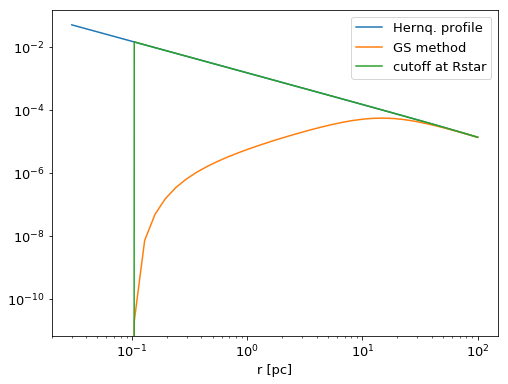

In [150]:
plt.figure(figsize=[8,6])
plt.plot(r, int_star/r**2, label='Hernq. profile')
plt.plot(r, int_star2/r**2, label='GS method')
plt.plot(r, int_star3/r**2, label='cutoff at Rstar')
plt.xlabel('r [pc]')
plt.xscale('log')
plt.yscale('log')
plt.legend()

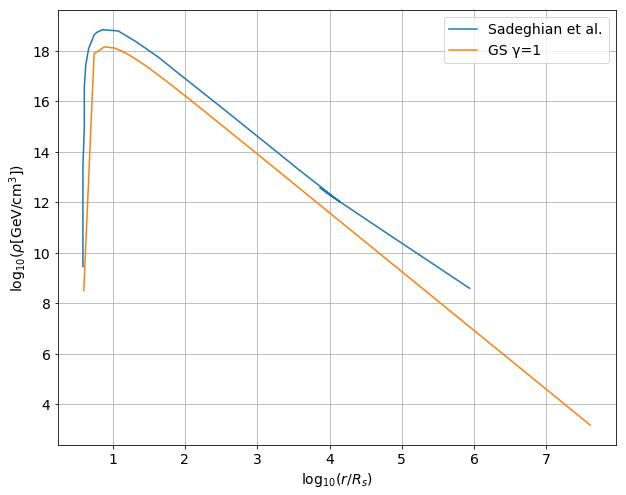

In [42]:
import pandas as pd
rho_GScomp = np.loadtxt('rho_sp1 compare with Hernq. SFW')
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,8))
      
convert = (units.GeV/units.cm**3/c**2).to(units.solMass/units.parsec**3).value
r = np.logspace(np.log10(4.0001*Rs.value), 1, 50)
# r_GS2 = np.logspace(np.log10((4+1e-8)*Rs.value), 2, 100)

rho_pl = (M/(2*a[0]**3)) * (a[0]/r)
# rho_H = (M/(2*np.pi*a[0]**3)) / ((r/a[0].value)*(1+r/a[0].value)**3)

# plt.plot(np.log10(r/Rs.value), np.log10(rho_H.value/convert), linestyle='--', color='k')

data = pd.read_csv('Dataset nonlog.csv')
# print(data)
x = data['0.5902439024390249']#*Rs[3]
y = data[' 8.586750788643535']#*0.026339067
# data.plot(kind='line', x=0, y=1)
plt.plot(x,y, label='Sadeghian et al.')
# plt.plot(np.log10(r/Rs.value),np.log10(rho.value/convert), label='me')
plt.plot(np.log10(r/Rs.value), np.log10(rho_GScomp/convert), label='GS γ=1')
plt.xlabel('log$_{10}(r/R_s)$')
plt.ylabel('log$_{10}(ρ$[GeV/cm$^3$])')
plt.legend()
plt.grid()

In [39]:
def H_integ_init2(a, Lmin, x_arr):
    int_rho_arr = []
    int_err = []

    for xi in x_arr:

        def f_integ3(L2, eps_i):
            Lmax2 = 2*xi**2*(1/(xi+1) - eps_i)

            # distribution function
            f_H = f_dist(eps_i)

            return 1/np.sqrt((Lmax2-L2)) * f_H

        # integration
        integ_rho = dblquad(f_integ3, 0, 1/(1+xi), 0, lambda eps_i: 2*xi**2*(1/(xi+1) - eps_i), epsrel=1e-3)
        int_rho_arr.append(integ_rho[0])
        int_err.append(integ_rho[1])
    return int_rho_arr, int_err

In [61]:
r2 = np.logspace(-2, 2, 40)
x_arr2 = r2/a[0].value
integr2, err2 = H_integ_init(a[0], 0, x_arr2)

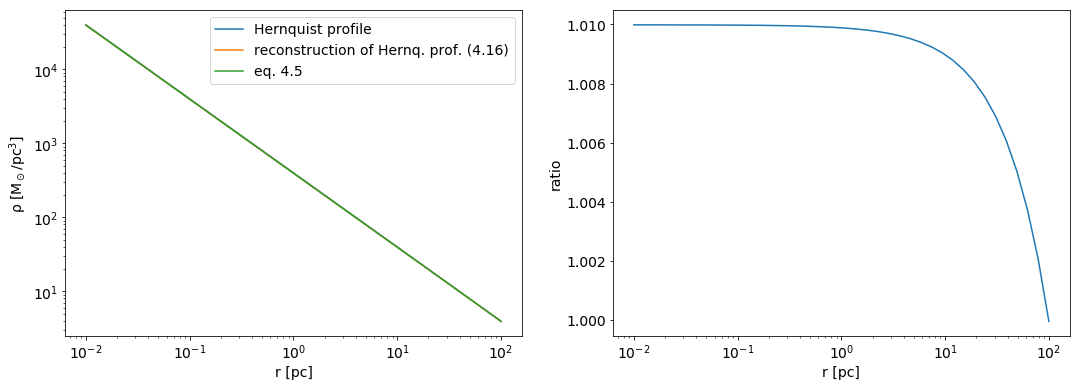

In [63]:
rho2 = rho2test(M, a[0], integr2, x_arr2)

plt.figure(figsize=(18,6))
rho_i = (M/(2*np.pi*a[0]**3)) / ((r2/a[0].value)*(1+r2/a[0].value)**3)

plt.subplot(121)
plt.plot(r2, rho_i, label='Hernquist profile')
plt.plot(r2, rho2, label='reconstruction of Hernq. prof. (4.16)')
plt.plot(r2, (M/a[0].value**3)/(2**0.5*(2*np.pi)**2*x_arr2)*integr2, label='eq. 4.5')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r [pc]')
plt.ylabel('ρ [M$_\odot$/pc$^3$]')
plt.legend()

plt.subplot(122)
plt.plot(r2, rho_i/rho2)

plt.xscale('log')
plt.xlabel('r [pc]')
plt.ylabel('ratio')
plt.show()